In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mediapipe opencv-python-headless

In [3]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import mediapipe as mp

In [4]:
# Define paths to datasets
paths = {
    "A": "/content/drive/MyDrive/FD/dataset_A", #Pappo Khan
    "B": "/content/drive/MyDrive/FD/dataset_B", #Asif
    "C": "/content/drive/MyDrive/FD/dateset_C", #AR Asif
    "D": "/content/drive/MyDrive/FD/dateset_D"  #Tanvir
}

In [5]:
# Initialize Mediapipe for face detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.2)

In [6]:
# Function to prepare training data
def prepare_training_data(data_paths):
    faces = []
    labels = []

    for label, path in data_paths.items():
        if not os.path.exists(path):
            print(f"Error: The directory {path} does not exist.")
            continue

        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            if os.path.isfile(img_path):
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if results.detections:
                    for detection in results.detections:
                        bboxC = detection.location_data.relative_bounding_box
                        ih, iw, _ = img.shape
                        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                        face_image = gray[y:y + h, x:x + w]
                        face_image_resized = cv2.resize(face_image, (160, 160))
                        faces.append(face_image_resized)
                        labels.append(label)

    faces = np.array(faces)
    labels = np.array(labels)

    return faces, labels

In [7]:
print(paths)
print(len(paths))
print(paths.keys())
print(paths.values())
print(paths.items())
print(paths.get("A"))
print(paths.get("B"))
print(paths.get("C"))
print(paths.get("D"))

{'A': '/content/drive/MyDrive/FD/dataset_A', 'B': '/content/drive/MyDrive/FD/dataset_B', 'C': '/content/drive/MyDrive/FD/dateset_C', 'D': '/content/drive/MyDrive/FD/dateset_D'}
4
dict_keys(['A', 'B', 'C', 'D'])
dict_values(['/content/drive/MyDrive/FD/dataset_A', '/content/drive/MyDrive/FD/dataset_B', '/content/drive/MyDrive/FD/dateset_C', '/content/drive/MyDrive/FD/dateset_D'])
dict_items([('A', '/content/drive/MyDrive/FD/dataset_A'), ('B', '/content/drive/MyDrive/FD/dataset_B'), ('C', '/content/drive/MyDrive/FD/dateset_C'), ('D', '/content/drive/MyDrive/FD/dateset_D')])
/content/drive/MyDrive/FD/dataset_A
/content/drive/MyDrive/FD/dataset_B
/content/drive/MyDrive/FD/dateset_C
/content/drive/MyDrive/FD/dateset_D


In [8]:
# Prepare data for training
faces, labels = prepare_training_data(paths)

# Normalize faces
faces = faces.astype('float32') / 255.0

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [9]:
# Split the data into training (80%), validation (10%), and testing (10%)
X_train, X_temp, y_train, y_temp = train_test_split(faces, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Print dataset sizes
print(f"Training data size: {X_train.shape[0]}")
print(f"Validation data size: {X_val.shape[0]}")
print(f"Testing data size: {X_test.shape[0]}")

Training data size: 320
Validation data size: 40
Testing data size: 40


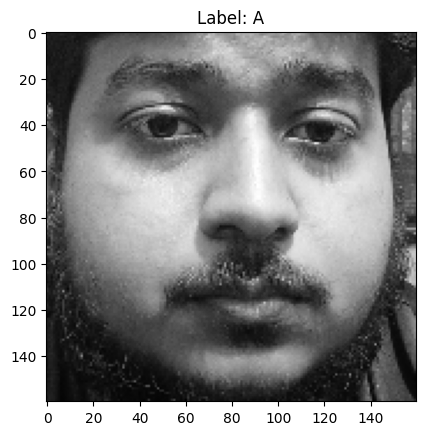

In [11]:
# Plot a sample face
plt.imshow(X_train[0], cmap='gray')
plt.title(f"Label: {label_encoder.inverse_transform([y_train[0]])[0]}")
plt.show()

In [12]:
# Build the CNN model
model = Sequential([
    Input(shape=(160, 160, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

In [13]:
# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with validation
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=32
)

Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4498 - loss: 1.3331 - val_accuracy: 0.7250 - val_loss: 0.6435
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9542 - loss: 0.2922 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 1.3063e-04


In [14]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


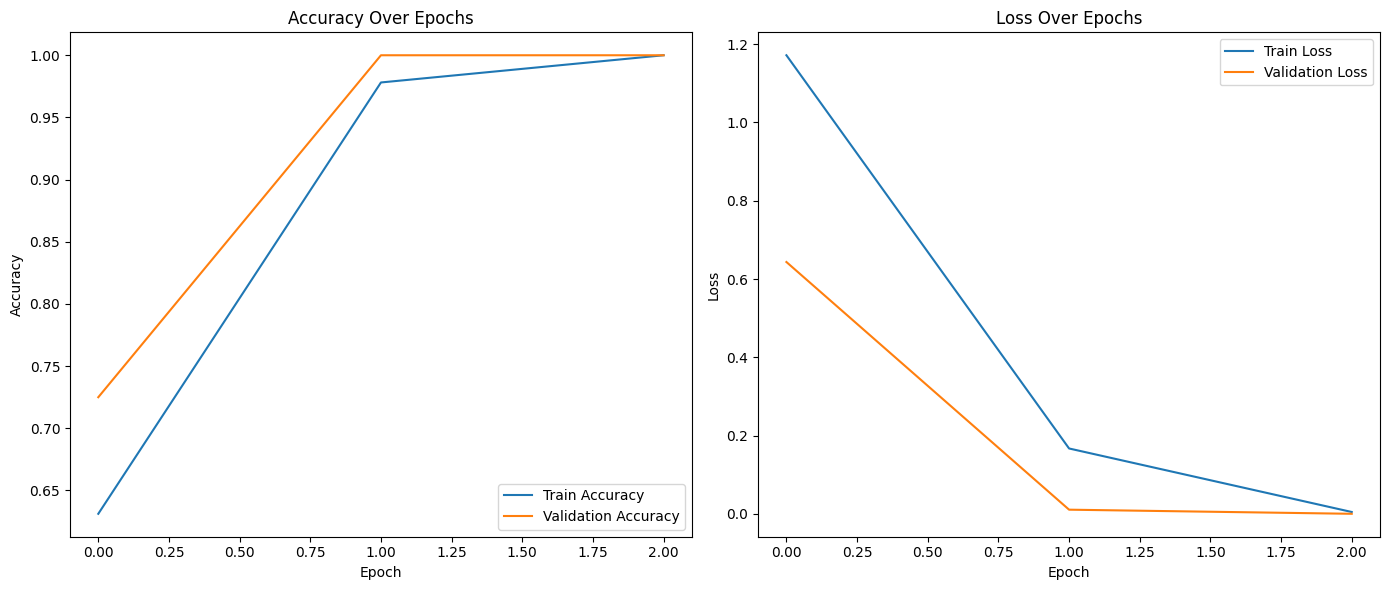

In [15]:
# Plot training history
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss Over Epochs')
plt.tight_layout()
plt.show()

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

2/2 - 0s - 233ms/step - accuracy: 1.0000 - loss: 8.5297e-05
Test Accuracy: 1.00


In [21]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=2)
print(f"Train Accuracy: {train_accuracy:.2f}")

10/10 - 5s - 545ms/step - accuracy: 1.0000 - loss: 1.5522e-04
Train Accuracy: 1.00


In [22]:
# Evaluate the model on the Validation
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {val_accuracy:.2f}")

2/2 - 1s - 422ms/step - accuracy: 1.0000 - loss: 1.3063e-04
Validation Accuracy: 1.00


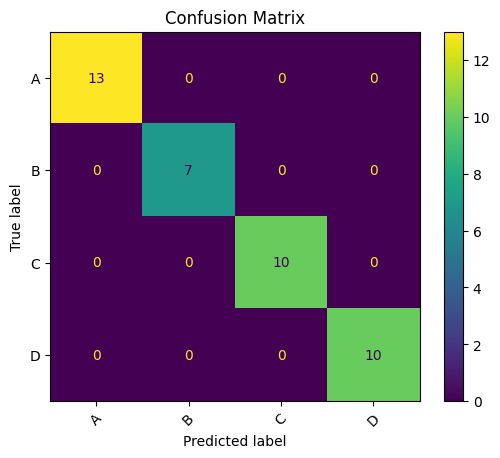

In [17]:
# Display confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

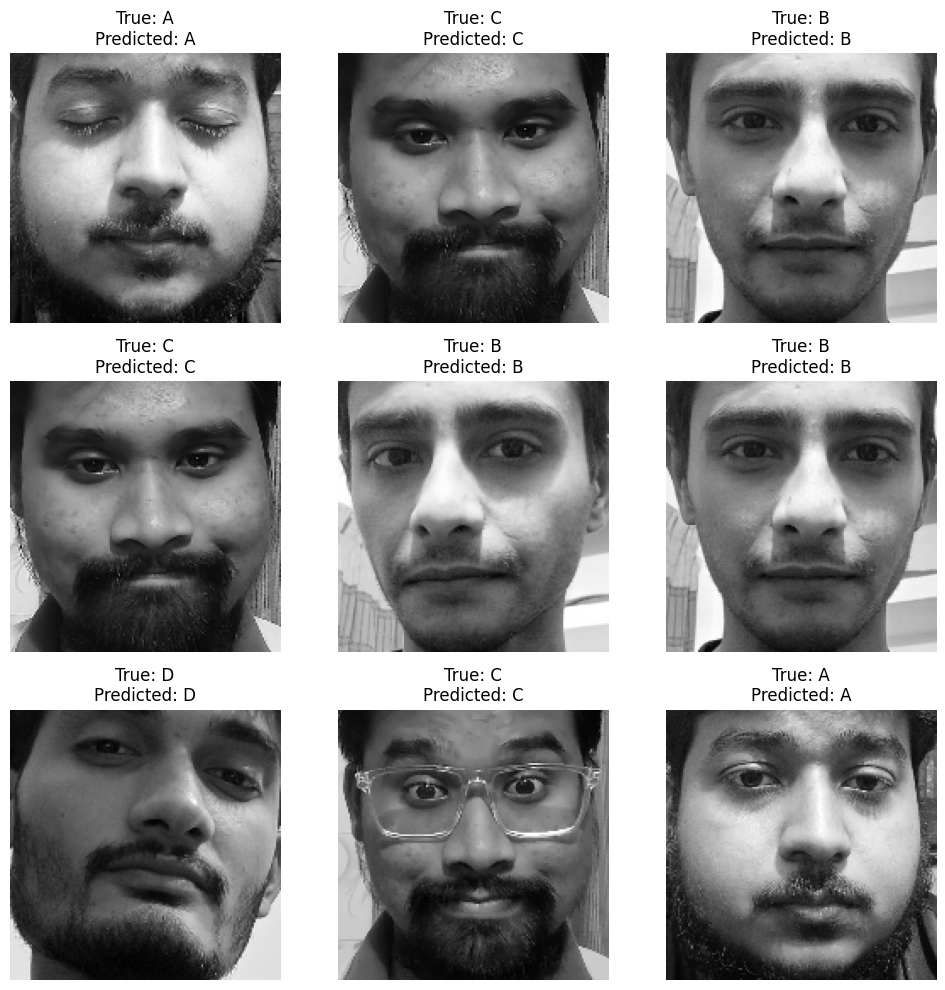

In [18]:
# Display some test images with predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx].reshape(160, 160), cmap='gray')
    true_label = label_encoder.inverse_transform([y_test[idx]])[0]
    predicted_label = label_encoder.inverse_transform([predicted_labels[idx]])[0]
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# Save the trained model
model.save("model.h5")
print("Model trained and saved as model.h5")

Model trained and saved as model.h5
